# Fake News Prediction

### Importing Libraries and Datasets

In [6]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [7]:
PATH = "../News.csv"
dataset = pd.read_csv(PATH, index_col=0)
dataset.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


### Data preprocessing

In [8]:
dataset.shape

(44919, 5)

In [9]:
dataset.drop(["title", "subject", "date"], axis=1, inplace=True)
dataset.head()

,text,class
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [10]:
dataset.isnull().sum()

text     0
class    0
dtype: int64

In [11]:
# shuffeling the dataset
dataset = dataset.sample(frac=1)
dataset.reset_index(inplace=True)
dataset.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

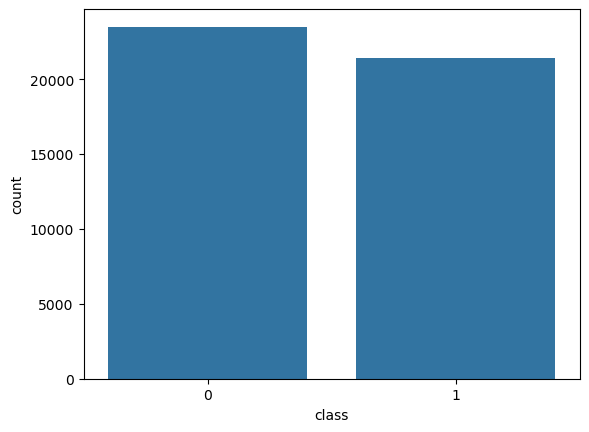

In [12]:
sb.countplot(data=dataset, x="class", order=dataset["class"].value_counts().index)

### Preprocessing and analysis of News column

In [ ]:
import re
import nltk
from tqdm import tqdm

nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def process_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        sentence = re.sub(r"[^\w\s]", "", str(sentence))
        preprocessed_text.append(
            " ".join(
                token.lower()
                for token in str(sentence).split()
                if token not in stopwords.words("english")
            )
        )

    return preprocessed_text

In [15]:
preprocessed_review = process_text(dataset["text"].values)
dataset["text"] = preprocessed_review
dataset.head()

100%|██████████| 44919/44919 [32:03<00:00, 23.35it/s]    


,text,class
0,washington reuters president barack obama meet...,1
1,wow cnn host chris cuomo tells viewers illegal...,0
2,we reporting unbelievable trend noncitizen gre...,0
3,new york reuters more 60 percent americans wou...,1
4,on thursday republicans congress voted overtur...,0


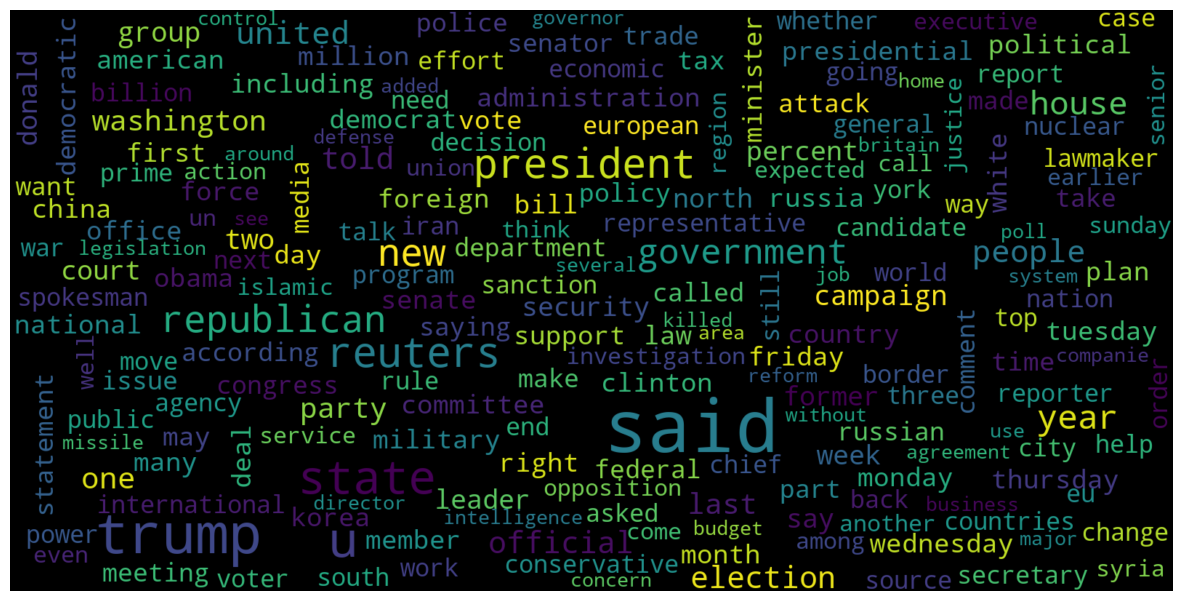

In [23]:
# Real News
from wordcloud import WordCloud

consolidated = " ".join(
    word for word in dataset["text"][dataset["class"] == 1].astype(str)
)

wordcloud = WordCloud(
    width=1600, height=800, random_state=21, max_font_size=100, collocations=False
)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud.generate(consolidated), interpolation="bilinear")
plt.axis("off")
plt.show()

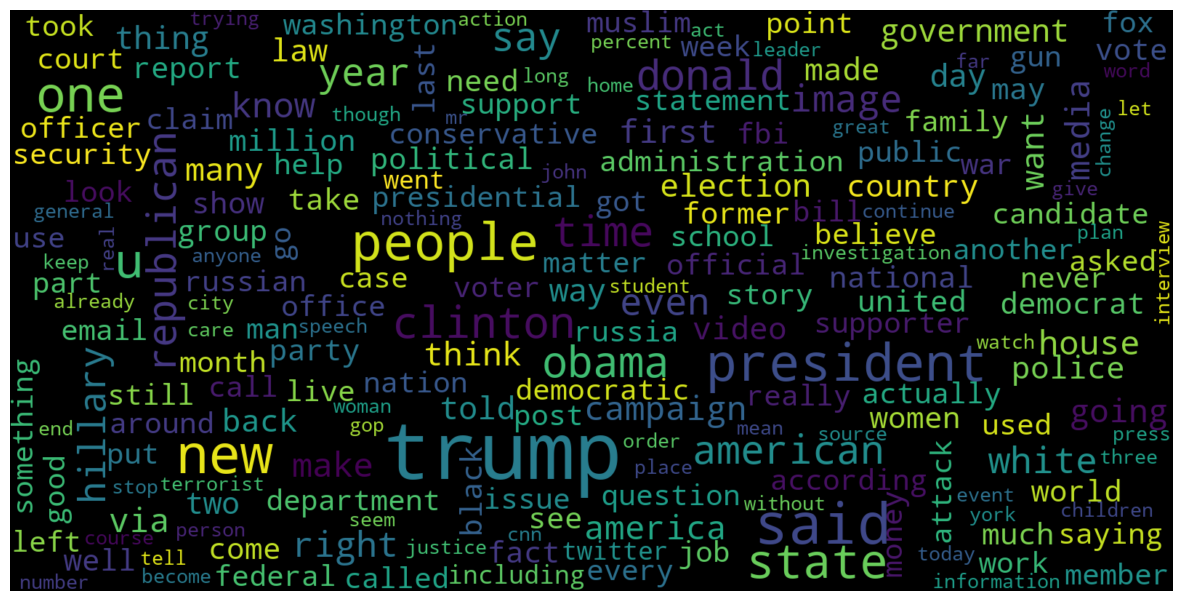

In [20]:
# Fake News
consolidated = ' '.join(
    word for word in dataset['text'][dataset['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

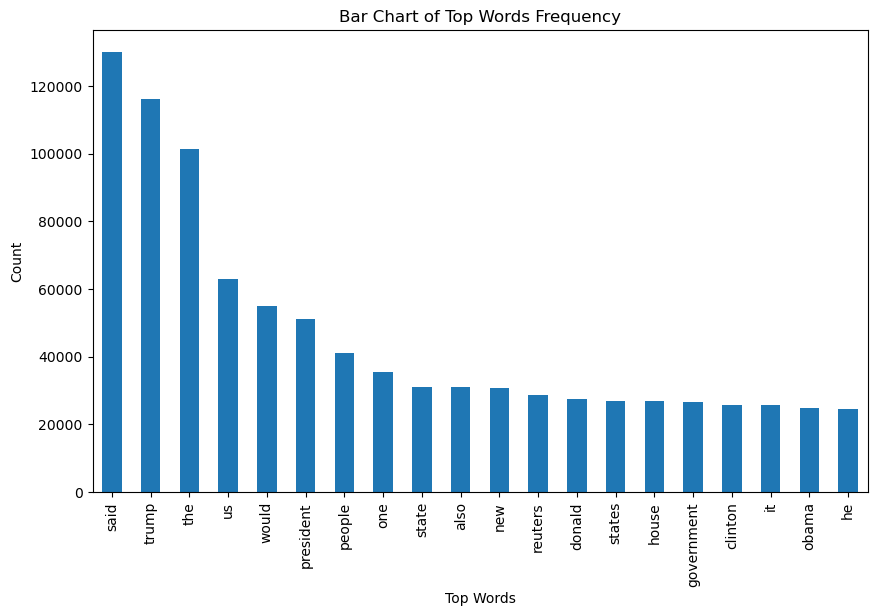

In [24]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]


common_words = get_top_n_words(dataset["text"], 20)
df1 = pd.DataFrame(common_words, columns=["Review", "count"])

df1.groupby("Review").sum()["count"].sort_values(ascending=False).plot(
    kind="bar",
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency",
)

### Converting text into Vectors

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    dataset["text"], dataset["class"], test_size=0.2
)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
X_train = vectorization.fit_transform(X_train)
X_test = vectorization.transform(X_test)

### Model training, Evaluation, and Prediction

In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

0.9937108668429108
0.9873107747105966


In [32]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

1.0
0.9962154942119323


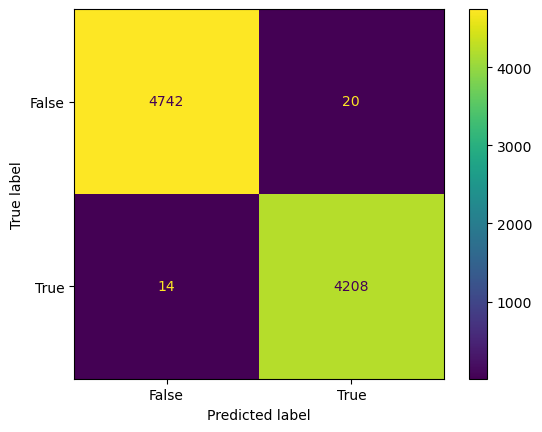

In [ ]:
# Confusion matrix of Results from Decision Tree classification

from sklearn import metrics

cm = metrics.confusion_matrix(y_test, model.predict(X_test))
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[False, True]
)

cm_display.plot()
plt.show()